In [ ]:
# Import library yang digunakan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import joblib

Preproses

In [ ]:
# load dataset
df = pd.read_csv('/content/dataset_mahasiswa_5000_fix.csv')

# 1. Cek missing values
print("Jumlah missing values:\n", df.isnull().sum())

# menghilangkan noise atau nilai yang terlalu ekstrem
df_filtered = df[
    (df['IPK'] <= 4.0) &
    (df['Skor_Psikologi'] >= 0) & (df['Skor_Psikologi'] <= 100)
].copy()

# Pisahkan fitur dan target
X = df_filtered[['IPK', 'Skor_Psikologi', 'Finansial']]
y = df_filtered['Status']

# Split data latih dan uji
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Jumlah missing values:
 Nama              0
IPK               0
Skor_Psikologi    0
Finansial         0
Status            0
dtype: int64


In [ ]:
# 1. GridSearchCV untuk Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Inisialisasi RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# GridSearchCV untuk mencari parameter terbaik
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"Best Parameters from Grid Search: {grid_search.best_params_}")

# Model terbaik dari GridSearch
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters from Grid Search: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# 2. Cross-validation untuk evaluasi
cv_scores = cross_val_score(best_rf_model, X, y, cv=5)
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean()}")


Cross-Validation Scores: [0.94031414 0.95183246 0.95597484 0.94339623 0.95387841]
Mean Cross-Validation Score: 0.9490792145499249


In [ ]:
# 3. Evaluasi Model pada Data Test
y_pred = best_rf_model.predict(X_test)

# Menampilkan classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Evaluasi AUC (Area Under Curve)
roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test), multi_class='ovr')
print(f"\nAUC Score: {roc_auc}")


Classification Report:
              precision    recall  f1-score   support

        Aman       0.95      0.98      0.97       319
  Bermasalah       0.95      0.88      0.91       160
       Siaga       0.97      0.97      0.97       476

    accuracy                           0.96       955
   macro avg       0.96      0.95      0.95       955
weighted avg       0.96      0.96      0.96       955


AUC Score: 0.9613358614251147


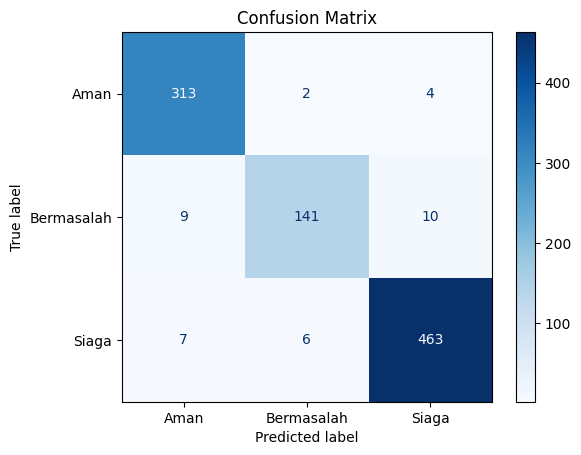

In [ ]:
#menampilkan matriks confusion untuk mengetahui prediksi setiap kelas
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


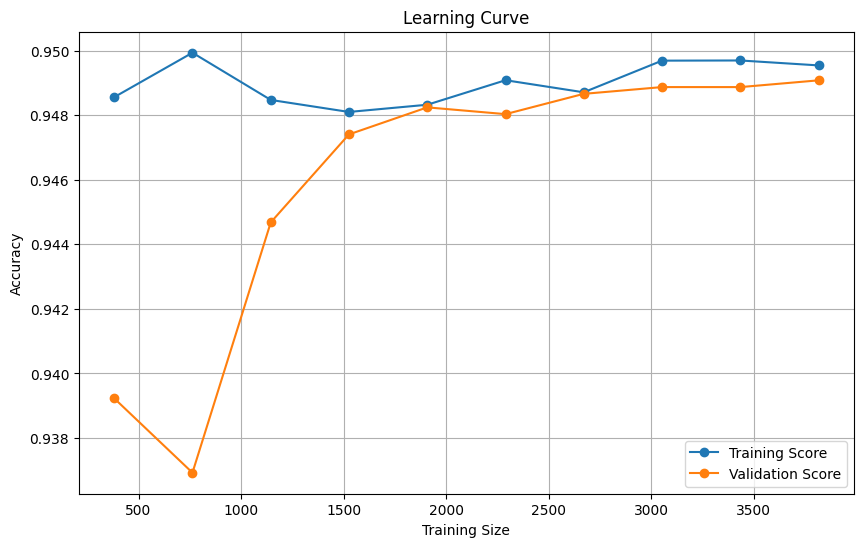

In [ ]:
# menampilkan kurva antara training dan validasi untuk mengetahui hasil prediksi model
train_sizes, train_scores, test_scores = learning_curve(
    best_rf_model, X, y, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', label='Validation Score')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


Feature Importances:
IPK: 0.5331082503136428
Skor_Psikologi: 0.3156068080204035
Finansial: 0.1512849416659536


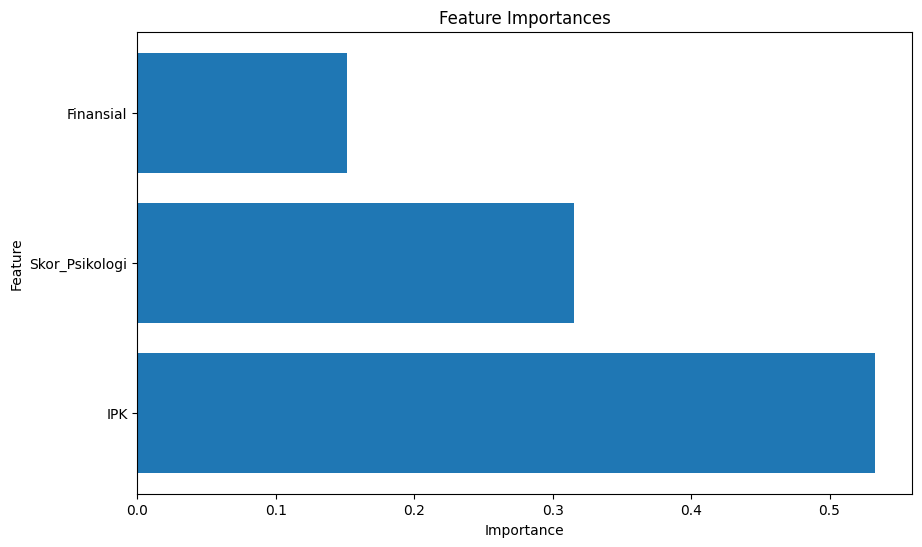

In [ ]:
# 4. Feature Importances
feature_importances = best_rf_model.feature_importances_
print("\nFeature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")

# Visualisasi Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

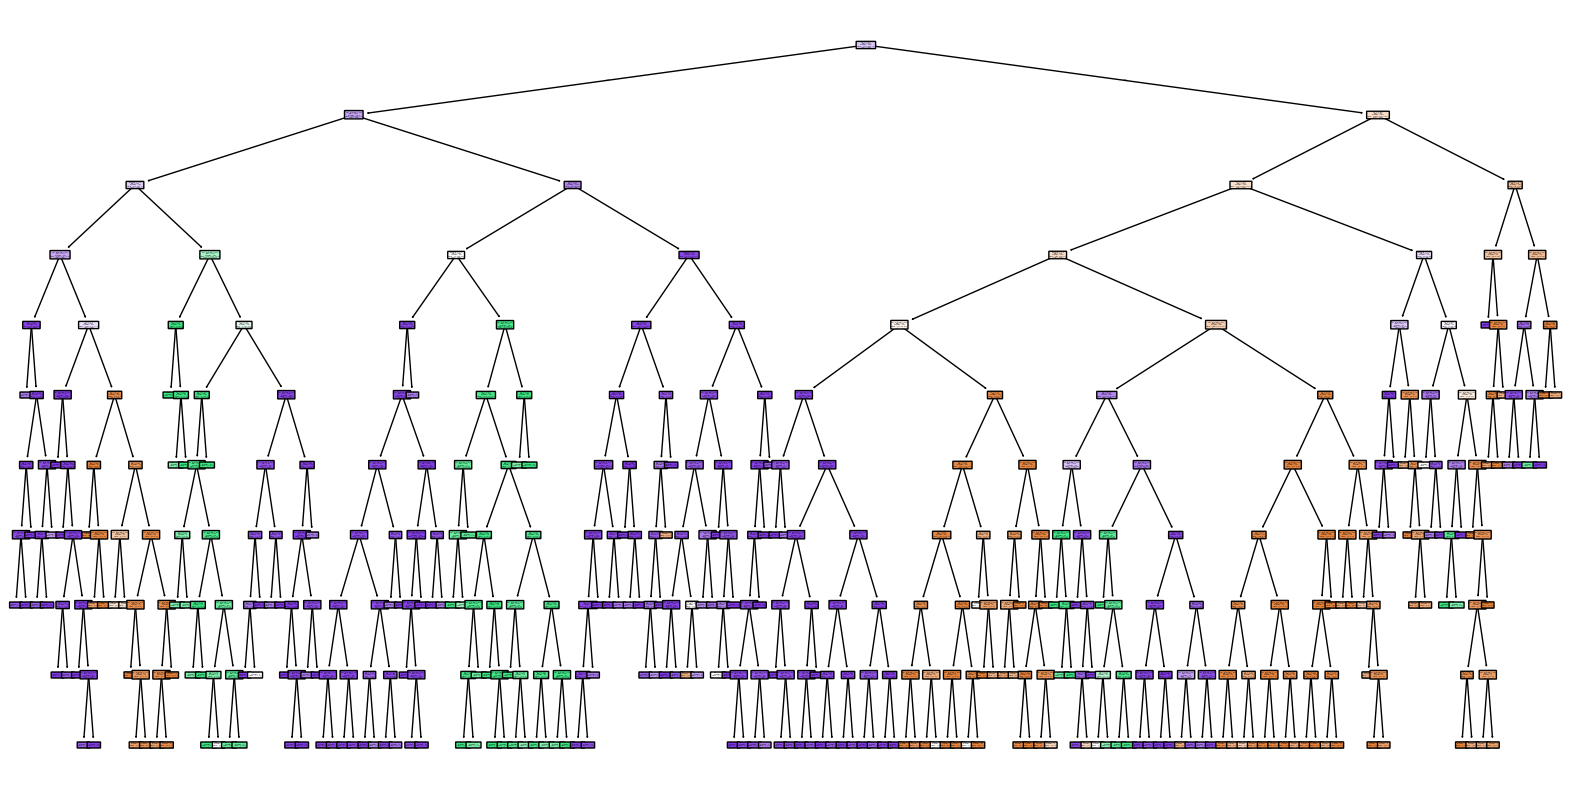

In [ ]:
# 5. Visualisasi Pohon Keputusan Pertama dalam Random Forest
# Memilih pohon pertama untuk divisualisasikan
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(best_rf_model.estimators_[0], filled=True, feature_names=X.columns, class_names=best_rf_model.classes_, rounded=True)
plt.show()

In [ ]:
# 6. Menyimpan Model ke dalam File .pkl
joblib.dump(best_rf_model, 'random_forest_model.pkl')

print("\nModel berhasil disimpan dalam 'random_forest_model.pkl'")


Model berhasil disimpan dalam 'random_forest_model.pkl'


In [ ]:
# Contoh input ambigu (nilai pertengahan)
ambiguous_inputs = pd.DataFrame({
    'IPK': [2.5, 3.0, 2.7],
    'Skor_Psikologi': [60, 70, 65],
    'Finansial': [50, 60, 55]
})

# Prediksi kelas
predicted_classes = best_rf_model.predict(ambiguous_inputs)
# Probabilitas prediksi
predicted_probs = best_rf_model.predict_proba(ambiguous_inputs)

# Tampilkan hasil
for i, row in ambiguous_inputs.iterrows():
    print(f"\nInput ke-{i+1}:")
    print(row)
    print(f"Prediksi kelas: {predicted_classes[i]}")

    # Tampilkan probabilitas per kelas
    for cls, prob in zip(best_rf_model.classes_, predicted_probs[i]):
        print(f"  → Probabilitas {cls}: {prob:.4f}")



Input ke-1:
IPK                2.5
Skor_Psikologi    60.0
Finansial         50.0
Name: 0, dtype: float64
Prediksi kelas: Siaga
  → Probabilitas Aman: 0.0301
  → Probabilitas Bermasalah: 0.2267
  → Probabilitas Siaga: 0.7433

Input ke-2:
IPK                3.0
Skor_Psikologi    70.0
Finansial         60.0
Name: 1, dtype: float64
Prediksi kelas: Siaga
  → Probabilitas Aman: 0.1529
  → Probabilitas Bermasalah: 0.0186
  → Probabilitas Siaga: 0.8285

Input ke-3:
IPK                2.7
Skor_Psikologi    65.0
Finansial         55.0
Name: 2, dtype: float64
Prediksi kelas: Siaga
  → Probabilitas Aman: 0.0737
  → Probabilitas Bermasalah: 0.0644
  → Probabilitas Siaga: 0.8618
